# Colab Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch

device = torch.device("cuda")
print("GPU allocated:", torch.cuda.get_device_name(0))

GPU allocated: Tesla P100-PCIE-16GB


# Preparing Local Data

In [3]:
# copy from drive to local /data/
!mkdir /data
!cp /content/drive/MyDrive/data/pokemon_images.zip /data
!unzip -q -n /data/pokemon_images.zip -d /data/

In [4]:
experiment_name = "PokeTypeGAN_apr30"

DATASET_ROOT = "/data/pokemon_images"
CHECKPOINT_ROOT = f"/content/drive/MyDrive/checkpoints/{experiment_name}"
TEST_RESULTS_ROOT = f"/content/drive/MyDrive/test_results/{experiment_name}"
GEN_RESULTS_ROOT = f"/content/drive/MyDrive/gen_results/{experiment_name}"

import os
os.makedirs(DATASET_ROOT, exist_ok=True)
os.makedirs(CHECKPOINT_ROOT, exist_ok=True)
os.makedirs(TEST_RESULTS_ROOT, exist_ok=True)
os.makedirs(GEN_RESULTS_ROOT, exist_ok=True)

# Imports and helper functions

In [5]:
import os
import random
import datetime
import io

import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import spectral_norm
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable, grad
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [6]:
def matplotlib_to_PIL(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buffer = io.BytesIO()
    fig.savefig(buffer, bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    return image

# Dataset Definition

In [7]:
class PokemonSpritesDataset(Dataset):
    """Pokemon Sprites dataset for conditional GANs, with front/back, type and shape label."""

    exclude_pokedex_id = [707, 708, 709, 867, 868]  # manually exclude some Pokemon's images
    
    def __init__(self, root_dir, use_shiny=False, use_back=True, use_shape=True, 
                 use_types=True, type2_prob=0.7, orient_weight=10):
        self.root_dir = root_dir
        self.use_shiny = use_shiny
        self.use_back = use_back
        self.use_shape = use_shape
        self.use_types = use_types
        self.type2_prob = type2_prob
        self.orient_weight = orient_weight

        self.sprites_dir = os.path.join(self.root_dir, "sprites")
        
        ## Pokemon metadata (labels)
        self.pokedex_df = pd.read_csv(os.path.join(root_dir, "pokedex.csv"))

        # Respectively binarize shape and type labels
        tmp_shape_labels = list(self.pokedex_df["shape"].unique())
        self.shape_binarizer = MultiLabelBinarizer().fit([tmp_shape_labels])
        self.shape_labels = self.shape_binarizer.classes_.tolist()

        tmp_type_labels = list(self.pokedex_df["type1"].unique())
        self.type_binarizer = MultiLabelBinarizer().fit([tmp_type_labels])
        self.type_labels = self.type_binarizer.classes_.tolist()

        self.orient_count_df = pd.DataFrame(np.zeros((1, 2), dtype=np.int32), 
                                         index=["Count"], columns=["front", "back"])
        self.shapes_count_df = pd.DataFrame(np.zeros((1, len(self.shape_labels)), dtype=np.int32), 
                                         index=["Count"], columns=self.shape_labels)
        self.types_count_df = pd.DataFrame(np.zeros((1, len(self.type_labels)), dtype=np.int32), 
                                         index=["Count"], columns=self.type_labels)

        ## Preprocessing
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        ## Read sprite images
        self.images = []
        self.labels = []

        for entry in os.scandir(self.sprites_dir):
            if not entry.is_dir():
                continue

            pokedex_id = int(entry.name[:4])

            if pokedex_id in self.exclude_pokedex_id:
                continue

            shape = self.pokedex_df.iloc[pokedex_id]["shape"]
            type1 = self.pokedex_df.iloc[pokedex_id]["type1"]
            type2 = self.pokedex_df.iloc[pokedex_id]["type2"]

            image_dirs = [
                os.path.join(entry.path, "front", "normal")
            ]
            if self.use_back:
                image_dirs.append(os.path.join(entry.path, "back", "normal"))
            if self.use_shiny:
                image_dirs.append(os.path.join(entry.path, "front", "shiny"))
                if self.use_back:
                    image_dirs.append(os.path.join(entry.path, "back", "shiny"))

            for image_dir in image_dirs:
                is_front = "/front/" in image_dir                
                
                for fn in os.listdir(image_dir):
                    if not fn.endswith(".png"):
                        continue

                    image = Image.open(os.path.join(image_dir, fn))
                    self.images.append(self.transform(image))

                    labels_binarized = self.binarize_label(is_front, shape, (type1, type2))
                    self.labels.append(labels_binarized)

                    self.orient_count_df.iloc[0]["front" if is_front else "back"] += 1
                    self.shapes_count_df.iloc[0][shape] += 1
                    self.types_count_df.iloc[0][type1] += 1
                    if type2 is not np.nan:
                        self.types_count_df.iloc[0][type2] += 1
        
        self.images = torch.from_numpy(np.stack(self.images))
        self.labels = torch.from_numpy(np.stack(self.labels))

        self.n_labels = self.labels.shape[-1]
        self.shape_labels_weights = np.asarray(
            self.shapes_count_df.iloc[0].max() / self.shapes_count_df.iloc[0])
        self.type_labels_weights = np.asarray(
            self.types_count_df.iloc[0].max() / self.types_count_df.iloc[0])

        self.labels_weights = []
        if self.use_back:
            self.labels_weights.append([self.orient_weight])
        if self.use_shape:
            self.labels_weights.append(self.shape_labels_weights)
        if self.use_types:
            self.labels_weights.append(self.type_labels_weights)
        self.labels_weights = np.concatenate(self.labels_weights)

        print("Images shape:", self.images.shape)
        print("Labels shape:", self.labels.shape)
        print("Labels weights:", self.labels_weights)

    def binarize_label(self, is_front, shape, types):
        labels = []
        
        if self.use_back:
            labels.append([1] if is_front else [0])

        if self.use_shape:
            labels.append(self.shape_binarizer.transform([[shape]])[0])

        if self.use_types:
            type_x = self.type_binarizer.transform([[types[0]]])[0].astype(float)  # type 1
            if len(types) == 2 and types[1] is not np.nan:
                type_x += self.type_binarizer.transform([[types[1]]])[0] * self.type2_prob
            labels.append(type_x)

        return np.concatenate(labels)

    def target_binarized_label_mask(self, orient=False, shape=False, types=False):
        """Return the mask to extract the target part from the binarized label."""
        
        assert(orient + shape + types == 1)  # only one of the orient, shape, types can be true

        mask = torch.zeros(self.n_labels).bool()
        if orient:
            assert(self.use_back)
            mask[0] = True
        
        if shape:
            assert(self.use_shape)
            start_idx = 1 if self.use_back else 0
            mask[start_idx: start_idx + len(self.shape_labels)] = True
        
        if types:
            assert(self.use_types)
            start_idx = 0
            if self.use_back:
                start_idx += 1
            if self.use_shape:
                start_idx += len(self.shape_labels)
            mask[start_idx: start_idx + len(self.type_labels)] = True
        
        return mask
    
    def type_onehot_label_to_num_label(self, type_label, ignore_type2=True):
        # label must have length len(self.type_labels)
        type_num_labels = (type_label == 1).nonzero()[:, 1]  # only use the primary type
        return type_num_labels

    def inverse_binarize_label(self, labels):
        # input labels: (N, n_labels)
        all_labels_text = []

        for i in range(labels.shape[0]):
            labels_text = []

            if self.use_back:
                if labels[i][self.target_binarized_label_mask(orient=True)]:
                    labels_text.append("front")
                else:
                    labels_text.append("back")
            
            if self.use_shape:
                labels_text.append(self.shape_binarizer.inverse_transform(
                    labels[i][self.target_binarized_label_mask(shape=True)][None, :].numpy())[0][0]
                )
            
            if self.use_types:
                types_x = labels[i][self.target_binarized_label_mask(types=True)].numpy()
                type1_x = np.array(types_x == 1., dtype=float)
                type_text = list(self.type_binarizer.inverse_transform(type1_x[None, :])[0])  # [type1]
                if np.any(types_x == self.type2_prob):  # if has type 2
                    type2_x = np.array(types_x == self.type2_prob, dtype=float)
                    type_text += list(self.type_binarizer.inverse_transform(type2_x[None, :])[0])
                labels_text.append(type_text)

            all_labels_text.append(labels_text)

        return all_labels_text

    def gen_random_labels(self, batch_size, test=False):
        random_labels = []
        for i in range(batch_size):
            # Sample labels uniformly
            is_front = random.choice([True, False])
            rand_shape = random.choice(self.shape_labels)
            rand_types = (random.choice(self.type_labels), )   # only for single type
                
            random_labels.append(self.binarize_label(is_front, rand_shape, rand_types))

        return torch.from_numpy(np.stack(random_labels))

    def make_images_grid(self, images, labels, row=8, col=8):
        # draw images grid with input tensor image batch
        fig, axs = plt.subplots(row, col, figsize=(row * 3, col * 2))

        for i in range(row):
            for j in range(col):
                idx = i * col + j
                label_text = self.inverse_binarize_label(labels[idx].unsqueeze(0))[0]
                axs[i][j].axis('off')
                axs[i][j].imshow(np.transpose(images[idx] * 0.5 + 0.5, (1, 2, 0)))
                axs[i][j].set_title(str(label_text)[1:-1], fontsize=12)

        image = matplotlib_to_PIL(fig)
        plt.close(fig)
        return image

    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [8]:
dataset = PokemonSpritesDataset(DATASET_ROOT, use_shiny=False, use_back=True, use_shape=False, use_types=True)

Images shape: torch.Size([5092, 3, 96, 96])
Labels shape: torch.Size([5092, 19])
Labels weights: [10.          1.90425532  3.36466165  3.63821138  2.77089783  3.48249027
  3.04421769  2.39946381  1.43429487  3.99553571  1.57017544  2.02947846
  3.65306122  1.30847953  1.84536082  1.61261261  2.45205479  3.0862069
  1.        ]


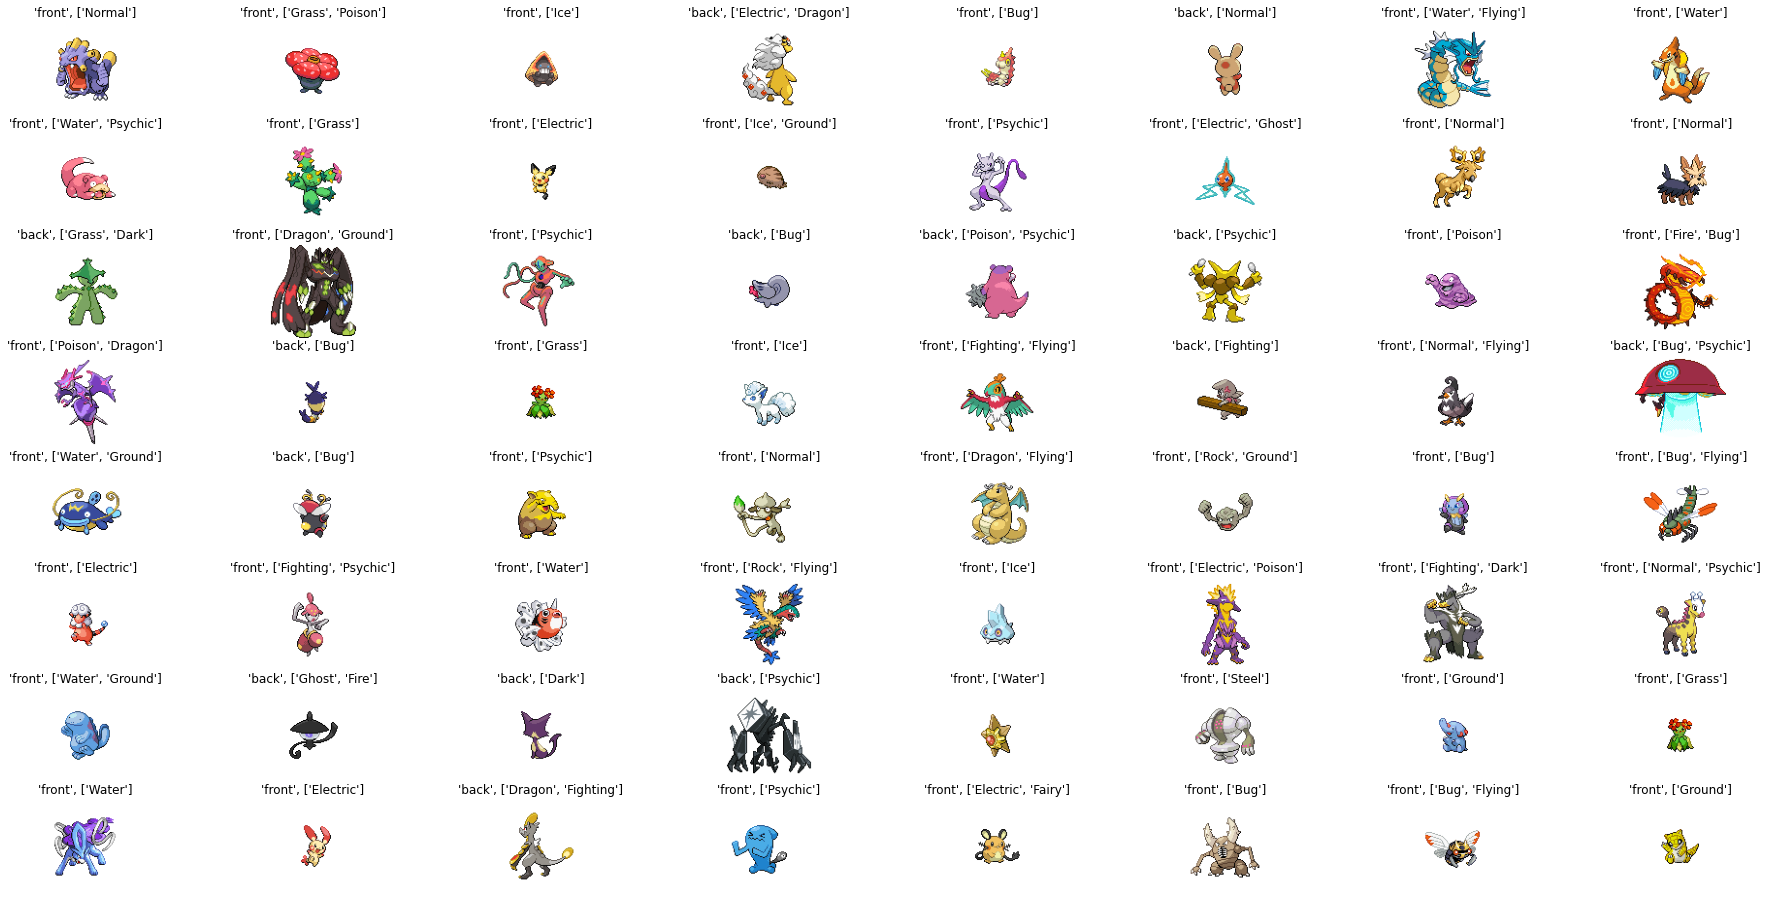

Orientation counts:


,front,back
Count,4080,1012


Shape counts:


,Armor,Arms,Ball,Blob,Bug-Wings,Fish,Heads,Humanoid,Legs,Quadruped,Squiggle,Tentacles,Upright,Wings
Count,213,230,257,202,138,236,82,813,147,946,223,93,1072,440


Type counts:


,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Count,470,266,246,323,257,294,373,624,224,570,441,245,684,485,555,365,290,895


In [9]:
# dispaly example training batch and statistics
dataloader_example = DataLoader(dataset, batch_size=64, shuffle=True)
example_images, example_labels = next(iter(dataloader_example))
display(dataset.make_images_grid(example_images, example_labels))

print("Orientation counts:")
display(dataset.orient_count_df)
print("Shape counts:")
display(dataset.shapes_count_df)
print("Type counts:")
display(dataset.types_count_df)

Text(0, 0.5, 'Count')

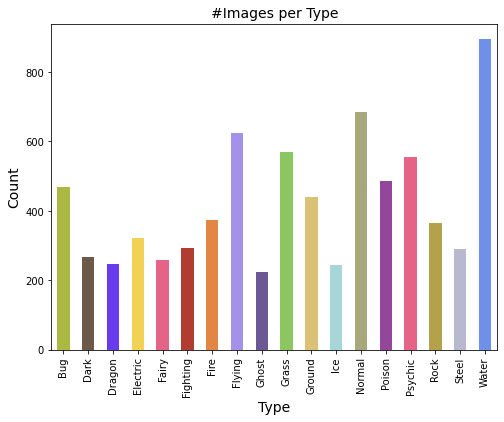

In [10]:
type_color_dict = {"Bug": "#abb842", "Dark": "#6c594a", "Dragon": "#693bef", "Electric": "#f2d254", 
                   "Fairy": "#e66388", "Fighting": "#b13d31", "Fire": "#e18644", 
                   "Flying": "#a491ea", "Ghost": "#6c5994", "Grass": "#8bc660", "Ground": "#dbc175",
                   "Ice": "#a6d6d7", "Normal": "#a8a87d", "Poison": "#94469b", "Psychic": "#e66388",
                   "Rock": "#b4a14b", "Steel": "#b8b8ce", "Water": "#708fe9"}
plt.figure(figsize=(8, 6))
dataset.types_count_df.iloc[0].plot.bar(color=type_color_dict.values())
plt.title("#Images per Type", fontsize=14)
plt.xlabel("Type", fontsize=14)
plt.ylabel("Count", fontsize=14)

Text(0, 0.5, 'Count')

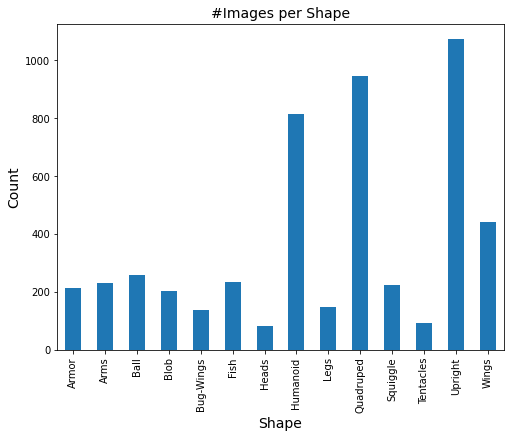

In [11]:
plt.figure(figsize=(8, 6))
dataset.shapes_count_df.iloc[0].plot.bar()
plt.title("#Images per Shape", fontsize=14)
plt.xlabel("Shape", fontsize=14)
plt.ylabel("Count", fontsize=14)

Text(0, 0.5, 'Count')

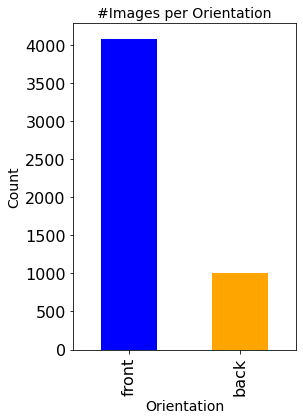

In [12]:
plt.figure(figsize=(4, 6))
plt.rcParams["font.size"] = 16
dataset.orient_count_df.iloc[0].plot.bar(color=["blue", "orange"])
plt.title("#Images per Orientation", fontsize=14)
plt.xlabel("Orientation", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Model definition

In [13]:
class AdditiveGaussianNoise(nn.Module):
    def __init__(self, std=0.1, linear_decay_step=200000):
        super().__init__()
        self.std = std
        self.linear_decay = self.std / linear_decay_step

    def std_decay_step(self):
        self.std = max(0, self.std - self.linear_decay)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

def decay_gauss_std(module):
    for m in module.modules():
        if isinstance(m, AdditiveGaussianNoise):
            m.std_decay_step()

In [14]:
class Generator(nn.Module):
    """
    Input: (N, dim_z, 1, 1), (N, n_labels)
    Output: (N, 3, 96, 96)
    """
    def __init__(self, dim_z, n_labels):
        super(Generator, self).__init__()

        self.dim_z = dim_z
        self.n_labels = n_labels

        self.latent_dim = dim_z + n_labels

        self.linear = nn.Sequential(
            nn.LazyConvTranspose2d(1024, kernel_size=6, stride=1, padding=0),
            nn.LeakyReLU(0.2),
        )

        self.backbone = nn.Sequential(*[
            self.upsample_block(512),
            self.upsample_block(256),
            self.upsample_block(128),
        ])

        self.gen = nn.Sequential(
            nn.LazyConvTranspose2d(3, kernel_size=4, stride=2, padding=1), 
            nn.Tanh()
        )

    def upsample_block(self, num_filters):
        layers = [
            nn.LazyConvTranspose2d(num_filters, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2),
            nn.LazyConv2d(num_filters, kernel_size=3, stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2),
            nn.LazyConv2d(num_filters, kernel_size=3, stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2)
        ]
        return nn.Sequential(*layers)

    def forward(self, noise, labels):
        noise_with_labels = torch.concat((noise, labels[:, :, None, None]), dim=1)
        init_feat_map = self.linear(noise_with_labels)
        final_feat_map = self.backbone(init_feat_map)
        image = self.gen(final_feat_map)
        return image

In [15]:
class Discriminator(nn.Module):
    """Assumption: all aux-labels are multi-label classification problem.
    Input: (N, 3, 96, 96)
    Output: (adv label (N, 1), aux labels (N, n_labels)]
    """

    def __init__(self, n_labels, embed_dim=128):
        super(Discriminator, self).__init__()

        self.n_labels = n_labels

        self.backbone = nn.Sequential(*[
            self.downsample_block(3, 64),
            self.downsample_block(64, 128),
            self.downsample_block(128, 256),
            self.downsample_block(256, 512)
        ])

        self.adv_clf = nn.Sequential(
            AdditiveGaussianNoise(),
            spectral_norm(nn.Conv2d(512, 1, kernel_size=6, stride=1, padding=0)),
            nn.Sigmoid()  # binary label
        )

        self.aux_clf = nn.Sequential(
            AdditiveGaussianNoise(),
            spectral_norm(nn.Conv2d(512, self.n_labels, kernel_size=6, stride=1, padding=0)),
            nn.Sigmoid()  # multi-label
        )

    def downsample_block(self, in_channels, out_channels):
        layers = [
            AdditiveGaussianNoise(),
            spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        return nn.Sequential(*layers)

    def forward(self, images):
        feat_maps = self.backbone(images)

        adv_label = self.adv_clf(feat_maps).squeeze().unsqueeze(1)  # (N, 1)
        aux_labels = self.aux_clf(feat_maps).squeeze()  # (N, n_labels)
        if self.n_labels == 1:
            aux_labels = aux_labels.unsqueeze(1)

        return adv_label, aux_labels, feat_maps.reshape(images.size(0), -1)

In [16]:
# Adapt from https://github.com/POSTECH-CVLab/PyTorch-StudioGAN/blob/master/src/utils/losses.py#L162
class Data2DataCrossEntropyLoss(nn.Module):
  
    def __init__(self, num_classes, embed_dim=128, temperature=0.5, m_p=0.95):
        super(Data2DataCrossEntropyLoss, self).__init__()

        self.num_classes = num_classes
        self.embed_dim = embed_dim

        self.temperature = temperature
        self.m_p = m_p

        self.cosine_similarity = torch.nn.CosineSimilarity(dim=-1)

        self.project_head = nn.Sequential(
            nn.Linear(512 * 6 * 6, self.embed_dim * 2),  # manually set to the dim of feature map
            nn.ReLU(),
            nn.Linear(self.embed_dim * 2, self.embed_dim)
        )
        self.embedding = nn.Embedding(num_classes, 128)

    def calculate_similarity_matrix(self, x, y):
        v = self.cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def make_index_matrix(self, labels):
        labels = labels.detach().cpu().numpy()
        num_samples = labels.shape[0]
        mask_multi, target = np.ones([self.num_classes, num_samples]), 0.0

        for c in range(self.num_classes):
            c_indices = np.where(labels == c)
            mask_multi[c, c_indices] = target
        return torch.tensor(mask_multi).type(torch.long).to(device)

    def remove_diag(self, M):
        h, w = M.shape
        assert h==w, "h and w should be same"
        mask = np.ones((h, w)) - np.eye(h)
        mask = torch.from_numpy(mask)
        mask = (mask).type(torch.bool)
        return M[mask].view(h, -1)

    def forward(self, feat_map, label):
        embed = self.project_head(feat_map)
        embed = F.normalize(embed, dim=1)

        proxy = self.embedding(label)
        proxy = F.normalize(proxy, dim=1)

        # calculate similarities between sample embeddings
        sim_matrix = self.calculate_similarity_matrix(embed, embed) + self.m_p - 1
        # remove diagonal terms
        sim_matrix = self.remove_diag(sim_matrix / self.temperature)
        # for numerical stability
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)  # when i=j, the similarity with itself
        sim_matrix = F.relu(sim_matrix) - sim_max.detach()

        # calculate similarities between sample embeddings and the corresponding proxies
        smp2proxy = self.cosine_similarity(embed, proxy)
        # make false negative removal
        removal_fn = self.remove_diag(self.make_index_matrix(label)[label])
        # apply the negative removal to the similarity matrix
        improved_sim_matrix = removal_fn * torch.exp(sim_matrix).to(device)

        # compute positive attraction term
        pos_attr = F.relu((self.m_p - smp2proxy) / self.temperature)
        # compute negative repulsion term
        neg_repul = torch.log(torch.exp(-pos_attr) + improved_sim_matrix.sum(dim=1))
        # compute data to data cross-entropy criterion
        criterion = pos_attr + neg_repul

        return criterion.mean()

In [17]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Training

## Helper functions

In [18]:
def save_generated_batch_from_fix_noise(save_dir, generator, iters, input):
    iters_k = iters // 1000

    generator.eval()
    with torch.no_grad():
        gen_images = generator(*input).detach().cpu()
    image = dataset.make_images_grid(gen_images, fixed_aux_labels.detach().cpu())

    img_path = os.path.join(save_dir, f"{iters_k:05d}k.png")
    image.save(img_path)
    print("Saved generated image grid to", img_path)

def save_model(save_dir, generator, discriminator, iters):
    iters_k = iters // 1000
    G_path = os.path.join(save_dir,  f"{iters_k:05d}k-G.pth")
    D_path = os.path.join(save_dir,  f"{iters_k:05d}k-D.pth")

    torch.save(generator.state_dict(), G_path)
    torch.save(discriminator.state_dict(), D_path)

    print("Saved generator to", G_path, "and discriminator to", D_path)

def load_model(save_dir, generator, discriminator, iters):
    iters_k = iters // 1000
    G_path = os.path.join(save_dir,  f"{iters_k:05d}k-G.pth")
    D_path = os.path.join(save_dir,  f"{iters_k:05d}k-D.pth")

    generator.load_state_dict(torch.load(G_path))
    discriminator.load_state_dict(torch.load(D_path))
    
    print("Loaded generator from", G_path, "and discriminator from", D_path)

In [19]:
def gen_adv_labels(batch_size, real, smooth_real=False, noisy=False):
    # output: (N, 1)
    label = 1. if real else 0.
    labels = torch.full((batch_size, 1), label, dtype=torch.float)

    if noisy:
        # randomly flip real and fake labels with probability 0.05
        filped_labels = 1 - labels
        if_filp = torch.rand((batch_size, )) < 0.05
        labels[if_filp] = filped_labels[if_filp]

    if smooth_real and real:
        labels[labels == 1] = 0.9

    return labels

def gen_random_z(dim_z, batch_size):
    return torch.randn((batch_size, dim_z, 1, 1))

In [20]:
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738

import torch
import torch.nn.functional as F


def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    # x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.3)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    # x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 1.5) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    # x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.3) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.25):  # origin: 0.5
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}


## Initialization

In [21]:
# global settings
def seed_everything(seed=7777):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
seed_everything()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


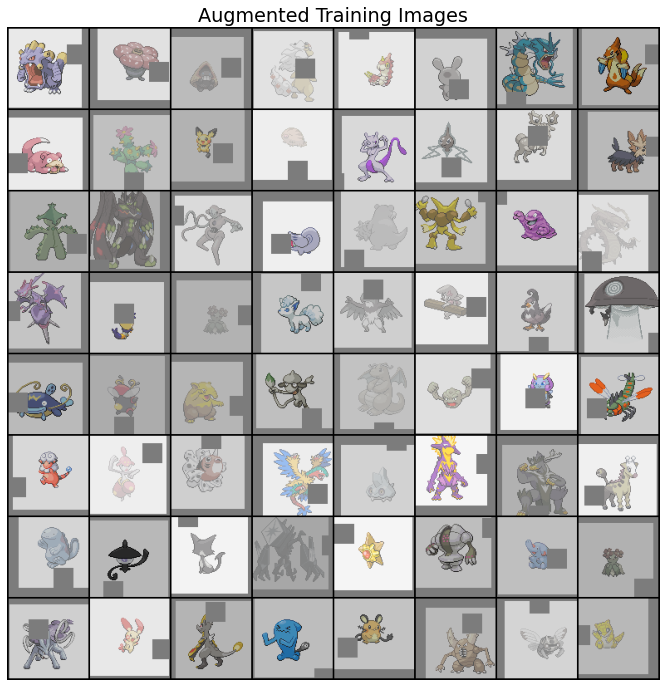

In [22]:
DA_policy = "color,translation,cutout"

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Augmented Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(DiffAugment(example_images, policy=DA_policy), normalize=True), (1, 2, 0)))

In [23]:
# Hyper-parameters
n_epochs = 10000

dim_z = 100

batch_size = 128

lr_D = 0.0002
lr_G = 0.0002

lambda_aux = 0.25
lambda_clr = 0.03

In [24]:
## Models
generator = Generator(dim_z, dataset.n_labels).to(device)
generator.apply(weights_init)

discriminator = Discriminator(dataset.n_labels).to(device)
discriminator.apply(weights_init)

## Dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

## Losses
# real/fake binary classification
adv_criterion = nn.BCELoss()

# multi-label classification, with label weigths
aux_criterion = nn.BCELoss(reduction="none")  
aux_weights = torch.tensor(dataset.labels_weights).to(device)

# contrastive loss for types
clr_criterion = Data2DataCrossEntropyLoss(num_classes=dataset.n_labels - 1).to(device)

## Optimizers
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5, 0.999))
optimizer_clr = optim.Adam(clr_criterion.parameters(), lr=lr_D, betas=(0.5, 0.999))

## Fixed noise for testing
fixed_noise = gen_random_z(dim_z, 64).to(device)
fixed_aux_labels = dataset.gen_random_labels(64, test=True).float().to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Training loop

In [24]:
# If start from scratch
iters = 0

In [25]:
# If resume from saved checkpoint
iters = 190000
load_model(CHECKPOINT_ROOT, generator, discriminator, iters)

Loaded generator from /content/drive/MyDrive/checkpoints/pokegen_type_reacgan_arange/00190k-G.pth and discriminator from /content/drive/MyDrive/checkpoints/pokegen_type_reacgan_arange/00190k-D.pth


In [ ]:
log = True
if log:
    # get_ipython().system("rm -rf ./runs")  # clean logs
    writer = SummaryWriter()
    %tensorboard --logdir ./runs  # default dir

In [112]:
for epoch in range(n_epochs):
    for i, (real_images, aux_labels) in enumerate(dataloader):
        
        real_images = real_images.to(device)
        aux_labels = aux_labels.float().to(device)
        clr_aux_labels = dataset.type_onehot_label_to_num_label(
            aux_labels[:, dataset.target_binarized_label_mask(types=True)]).to(device)
        cur_batch_size = real_images.shape[0]

        noise = gen_random_z(dim_z, cur_batch_size).to(device)
        random_aux_labels = dataset.gen_random_labels(cur_batch_size, test=False).float().to(device)
        clr_random_aux_labels = dataset.type_onehot_label_to_num_label(
            random_aux_labels[:, dataset.target_binarized_label_mask(types=True)]).to(device)

        discriminator.train()
        generator.train()

        ## Train D
        discriminator.zero_grad()

        # Real batch
        adv_pred_D_real, aux_pred_D_real, featmap_D_real = discriminator(
            DiffAugment(real_images, policy=DA_policy))
        adv_labels_D_real = gen_adv_labels(cur_batch_size, real=True, 
                                           smooth_real=True, noisy=False).to(device)
        
        adv_loss_D_real = adv_criterion(adv_pred_D_real, adv_labels_D_real)
        aux_loss_D_real = torch.mean(aux_weights * aux_criterion(aux_pred_D_real, aux_labels))
        clr_loss_D_real = clr_criterion(featmap_D_real, clr_aux_labels)

        # Fake batch
        fake_images = generator(noise, random_aux_labels)
        adv_pred_D_fake, aux_pred_D_fake, featmap_D_fake = discriminator(
            DiffAugment(fake_images.detach(), policy=DA_policy))
        adv_labels_D_fake = gen_adv_labels(cur_batch_size, real=False, noisy=False).to(device)
        
        adv_loss_D_fake = adv_criterion(adv_pred_D_fake, adv_labels_D_fake)
        aux_loss_D_fake = torch.mean(aux_weights * aux_criterion(aux_pred_D_fake, random_aux_labels))
        clr_loss_D_fake = clr_criterion(featmap_D_fake, clr_random_aux_labels)

        # Update D
        adv_loss_D = adv_loss_D_real + adv_loss_D_fake
        aux_loss_D = aux_loss_D_real + aux_loss_D_fake
        clr_loss_D = clr_loss_D_real + clr_loss_D_fake
        loss_D =  adv_loss_D + lambda_aux * aux_loss_D + lambda_clr * clr_loss_D
        loss_D.backward()
        optimizer_D.step()
        optimizer_clr.step()

        ## Train G
        generator.zero_grad()

        # Fake labels are real for generator cost
        adv_labels_G = gen_adv_labels(cur_batch_size, real=True,
                                      smooth_real=False, noisy=False).to(device)
        adv_pred_G, aux_pred_G, featmap_G = discriminator(DiffAugment(fake_images, policy=DA_policy))

        adv_loss_G = adv_criterion(adv_pred_G, adv_labels_G)
        aux_loss_G = torch.mean(aux_weights * aux_criterion(aux_pred_G, random_aux_labels))
        clr_loss_G = clr_criterion(featmap_G, clr_random_aux_labels)

        # Update G
        loss_G = adv_loss_G + lambda_aux * aux_loss_G + lambda_clr * clr_loss_G
        loss_G.backward()
        optimizer_G.step()

        ## At the end of each iteration
        iters += 1
        decay_gauss_std(discriminator)

        # Print training statistics
        D_x = adv_pred_D_real.mean().item()
        D_G_z1 = adv_pred_D_fake.mean().item()
        D_G_z2 = adv_pred_G.mean().item()

        if iters % 100 == 0:
            print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), 
                  f"Epoch [{epoch}/{n_epochs}] Batch [{i:02d}/{len(dataloader)}]:",
                  f"Loss_D adv/aux/clr: {adv_loss_D.item():.4f} / {aux_loss_D.item():.4f} / {clr_loss_D.item():.4f},",
                  f"Loss_G adv/aux/clr: {adv_loss_G.item():.4f} / {aux_loss_G.item():.4f} / {clr_loss_G.item():.4f}",
                  f"D(x): {D_x:.4f}, D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")
            if log:
                writer.add_scalar("D(x)", D_x, iters)
                writer.add_scalar("D(G(z))_2", D_G_z2, iters)
                writer.add_scalar("Loss_D_adv", adv_loss_D.item(), iters)
                writer.add_scalar("Loss_D_aux", aux_loss_D.item(), iters)
                writer.add_scalar("Loss_D_clr", clr_loss_D.item(), iters)
                writer.add_scalar("Loss_G_adv", adv_loss_G.item(), iters)
                writer.add_scalar("Loss_G_aux", aux_loss_G.item(), iters)
                writer.add_scalar("Loss_G_clr", clr_loss_G.item(), iters)
                writer.flush()

        # Saving G's output on fixed_noise and model weights
        if (iters % 1000 == 0) or ((epoch == n_epochs - 1) and (i == len(dataloader) - 1)):
            print("Saving generated images and model weights at iteration", iters)
            save_model(CHECKPOINT_ROOT, generator, discriminator, iters)
            save_generated_batch_from_fix_noise(TEST_RESULTS_ROOT, generator, iters, 
                                                (fixed_noise, fixed_aux_labels))


2022-04-30 14:02:45 Epoch [1/10000] Batch [33/40]: Loss_D adv/aux/clr: 1.2705 / 0.7736 / 7.4833, Loss_G adv/aux/clr: 0.9903 / 0.2441 / 3.1631 D(x): 0.5424, D(G(z)): 0.4573 / 0.3825
2022-04-30 14:03:23 Epoch [4/10000] Batch [13/40]: Loss_D adv/aux/clr: 1.2713 / 0.8419 / 7.4284, Loss_G adv/aux/clr: 0.8081 / 0.2222 / 3.1573 D(x): 0.4544, D(G(z)): 0.3741 / 0.4544
2022-04-30 14:04:01 Epoch [6/10000] Batch [33/40]: Loss_D adv/aux/clr: 1.3315 / 1.3088 / 9.6800, Loss_G adv/aux/clr: 0.8159 / 0.3665 / 4.2747 D(x): 0.4970, D(G(z)): 0.4514 / 0.4496
2022-04-30 14:04:39 Epoch [9/10000] Batch [13/40]: Loss_D adv/aux/clr: 1.2430 / 0.8272 / 7.4106, Loss_G adv/aux/clr: 0.9154 / 0.2160 / 3.1056 D(x): 0.5083, D(G(z)): 0.4151 / 0.4082
Saving generated images and model weights at iteration 254000
Saved generator to /content/drive/MyDrive/checkpoints/pokegen_type_reacgan_arange/00254k-G.pth and discriminator to /content/drive/MyDrive/checkpoints/pokegen_type_reacgan_arange/00254k-D.pth
Saved generated image 

KeyboardInterrupt: ignored

# Test

In [30]:
def gen_pokemon_with_types(type1, type2=None):
    test_noise = gen_random_z(dim_z, 64).to(device)
    test_aux_labels = torch.zeros(64, 19).to(device)
    test_aux_labels[:, 0] = 1.  # front

    test_aux_labels[:, 1 + dataset.type_labels.index(type1)] = 1.
    if type2 is not None:
        test_aux_labels[:, 1 + dataset.type_labels.index(type2)] = 0.7

    generator.eval()
    with torch.no_grad():
        gen_images = generator(test_noise, test_aux_labels).detach().cpu()

    title = type1 + ("" if type2 is None else f"+{type2}")
    fig = plt.figure(figsize=(12, 12))
    
    image_grid = torchvision.utils.make_grid(gen_images, normalize=True)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.title("Generated Images of type " + title, fontsize=14)
    plt.axis("off")

    image = matplotlib_to_PIL(fig)
    plt.close(fig)
    img_path = os.path.join(GEN_RESULTS_ROOT, f"{iters // 1000:05d}k-{title}.png")
    image.save(img_path)

In [ ]:
# Generate 64 image batches for all 171 type combinations
for i in range(len(dataset.type_labels)):
    type_1 = dataset.type_labels[i]
    print(f"Generating {type_1}")
    gen_pokemon_with_types(type_1)
    for j in range(len(dataset.type_labels)):
        if i == j:
            continue
        type_2 = dataset.type_labels[j]
        print(f"Generating {type_1}+{type_2}")
        gen_pokemon_with_types(type_1, type_2)

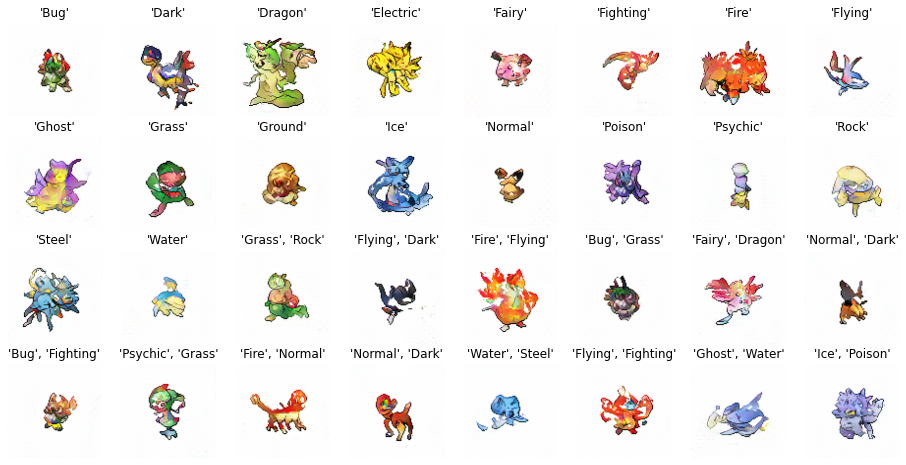

In [110]:
def make_images_grid(images, labels, row=4, col=8):
    # draw images grid with input tensor image batch
    fig, axs = plt.subplots(row, col, figsize=(row * 4, col))

    for i in range(row):
        for j in range(col):
            idx = i * col + j
            label_text = dataset.inverse_binarize_label(labels[idx].unsqueeze(0))[0][1]
            axs[i][j].axis('off')
            axs[i][j].imshow(np.transpose(images[idx] * 0.5 + 0.5, (1, 2, 0)))
            axs[i][j].set_title(str(label_text)[1:-1], fontsize=12)

    image = matplotlib_to_PIL(fig)
    plt.close(fig)
    return image

gen_labels = []
for label in dataset.type_labels:  # 18
    gen_labels.append(dataset.binarize_label("front", None, (label, )))

for i in range(14):
    type1 = random.choice(dataset.type_labels)
    type2 = random.choice(dataset.type_labels)
    while type1 == type2:
        type2 = random.choice(dataset.type_labels)
    gen_labels.append(dataset.binarize_label("front", None, (type1, type2)))
gen_labels = torch.from_numpy(np.stack(gen_labels)).float().to(device)

gen_noise = gen_random_z(dim_z, 32).to(device)

generator.eval()
with torch.no_grad():
    gen_images = generator(gen_noise, gen_labels).detach().cpu()

display(make_images_grid(gen_images, gen_labels.detach().cpu()))